<a href="https://colab.research.google.com/github/ramithuh/differentiable-trees/blob/main/problem%202%20(differentiable%20ancestors).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%bash
[[ ! -e /content/sample_data ]] && exit  ## run this cell only in colab
 
pip install optax -qqq
pip install networkx==2.5 -qqq
git clone https://github.com/ramithuh/differentiable-trees --quiet

In [2]:
%load_ext autoreload
%autoreload 2

import os
import sys

if(os.path.exists('/content/sample_data')):
  sys.path.append('differentiable-trees/')

import jax.numpy as jnp
import jax.nn as nn
import jax
import optax
import functools

import pydot
import numpy as np
from helpers import *

In [3]:
key = jax.random.PRNGKey(42)

## Sequences

In [4]:
# sequences (fixed)
n_leaves = 3

a = jnp.array([0,0,0,0]) 
b = jnp.array([1,0,0,1])
c = jnp.array([0,1,1,0])

# ancestral sequences (???)
d = jnp.array([1,1,1,1]) # ? 
e = jnp.array([0,0,0,0]) # ?

blank = jnp.array([0,0,0,0])

In [5]:
# similarity matrix (fixed)
sm = jnp.array([[0,1],
               [1,0]])

In [6]:
seqs = jnp.array([a,b,c,d,e],dtype=np.float32)

In [7]:
seqs

DeviceArray([[0., 0., 0., 0.],
             [1., 0., 0., 1.],
             [0., 1., 1., 0.],
             [1., 1., 1., 1.],
             [0., 0., 0., 0.]], dtype=float32)

## Tree Topology

In [8]:
# a-\
#   [d]---[e]
# b-/     /
#        /
# c-----/

# tree (???)
#               a,b,c,d,e
t = jnp.array([[0,0,0,1,0],  # a
               [0,0,0,1,0],  # b
               [0,0,0,0,1],  # c
               [0,0,0,0,1],  # d
               [0,0,0,0,0]]) # e

t = t.at[-1,-1].set(1) ### need to add this (so that the last sequence is matched with itself) 

### To generate a new topology run this line

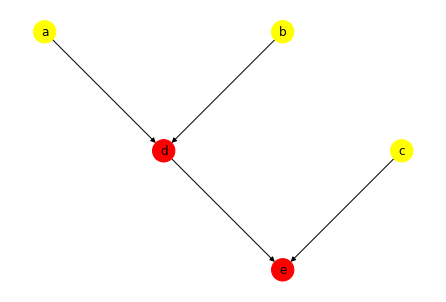

In [9]:
# t = generate_t(5) #for different topologies set seed = number
# t = t.at[-1,-1].set(1) ### need to add this (so that the last sequence is matched with itself) 
show_graph_with_labels(t,n_leaves)

### Function to compute total distance

In [10]:
def compute_cost(sequences, tree, verbose = False):
    if(verbose==True):
        show_graph_with_labels(t,n_leaves)
        
    selection = jnp.matmul(tree,sequences)
    # print(selection)
    
#     #method 1: (downside needs integers as we are indexing)
#     selection = selection.astype(int)
#     ans = sm[selection,sequences].sum()
    
    #method 2:
    ans = abs(selection - sequences).sum() ## works currently as sm is the basic config. need to think about extending
 
    return ans

In [11]:
seqs

DeviceArray([[0., 0., 0., 0.],
             [1., 0., 0., 1.],
             [0., 1., 1., 0.],
             [1., 1., 1., 1.],
             [0., 0., 0., 0.]], dtype=float32)

In [12]:
t

DeviceArray([[0, 0, 0, 1, 0],
             [0, 0, 0, 1, 0],
             [0, 0, 0, 0, 1],
             [0, 0, 0, 0, 1],
             [0, 0, 0, 0, 1]], dtype=int32)

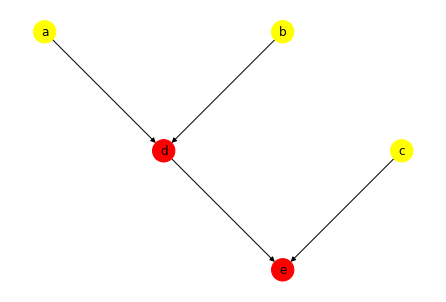

DeviceArray(12., dtype=float32)

In [13]:
compute_cost(seqs,t,1)

### Training

### initialize params

In [14]:
optimizer = optax.adam(.1)
# params = {'d': jnp.array([0,0,0.0,0.0]), 'e': jnp.array([0,0.0,0,0.0])}

params = {'d': jax.random.normal(key, (4,)), 'e': jax.random.normal(key, (4,))}


opt_state = optimizer.init(params)

In [15]:
params

{'d': DeviceArray([ 0.18693547,  1.0653335 , -1.5593132 , -1.5352962 ], dtype=float32),
 'e': DeviceArray([ 0.18693547,  1.0653335 , -1.5593132 , -1.5352962 ], dtype=float32)}

In [16]:
def combine_to_seq(params, seqs, temperature = 1):
    seqs = seqs.at[-2].set(nn.sigmoid(temperature*params['d']))
    seqs = seqs.at[-1].set(nn.sigmoid(temperature*params['e']))
    
    return seqs

In [17]:
def compute_loss(params, seqs_, t):
    seqs_ = combine_to_seq(params, seqs)
    
    loss  = compute_cost(seqs_,t)
    
    return loss

In [18]:
compute_loss(params, seqs, t)

DeviceArray(5.6412725, dtype=float32)

In [19]:
for _ in range(1500):
    grads = jax.grad(compute_loss)(params, seqs, t)
    
  
    if(_%100==0):
        temp = combine_to_seq(params, seqs)
        print("{:.5f}".format(compute_loss(params, seqs, t)),end = " seq = {")
        print(temp[-2],",",temp[-1],end="}\n")
        #print("new seq -> \n" , temp[-2],temp[-1], end = ")\n")
       
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)


5.64127 seq = {[0.54659826 0.7437085  0.17374523 0.1772201 ] , [0.54659826 0.7437085  0.17374523 0.1772201 ]}
4.07052 seq = {[0.03951567 0.01393093 0.00405536 0.01298501] , [0.03953307 0.7437085  0.17374523 0.01286346]}
4.02659 seq = {[0.0141719  0.00540679 0.00167978 0.00522486] , [0.01422665 0.7437085  0.17374523 0.00519177]}
4.01474 seq = {[0.00779098 0.00303142 0.00095948 0.00295873] , [0.0077801  0.7437085  0.17374523 0.00294676]}
4.00962 seq = {[0.00505064 0.0019857  0.00063398 0.00194916] , [0.00504386 0.7437085  0.17374523 0.00194101]}
4.00686 seq = {[0.00359249 0.00141966 0.00045549 0.00139591] , [0.0035828  0.7437085  0.17374523 0.00139404]}
4.00518 seq = {[0.00270466 0.0010737  0.00034557 0.00105764] , [0.00270184 0.7437085  0.17374523 0.00105697]}
4.00407 seq = {[0.00212037 0.00084452 0.00027239 0.00083331] , [0.0021212  0.7437085  0.17374523 0.00083236]}
4.00330 seq = {[0.00171553 0.00068372 0.00022086 0.00067482] , [1.7122298e-03 7.4370849e-01 1.7374523e-01 6.7518139e-04]

## Retrieving the new sequences array

In [20]:
temp = combine_to_seq(params, seqs)

In [21]:
discretized = jnp.round(combine_to_seq(params, seqs))

In [22]:
discretized

DeviceArray([[0., 0., 0., 0.],
             [1., 0., 0., 1.],
             [0., 1., 1., 0.],
             [0., 0., 0., 0.],
             [0., 1., 0., 0.]], dtype=float32)

### New cost

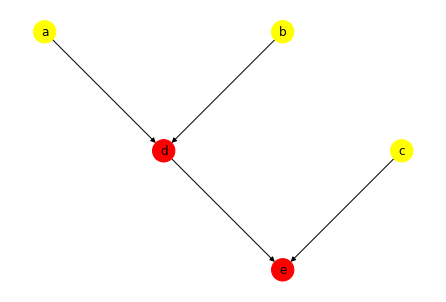

DeviceArray(4., dtype=float32)

In [23]:
compute_cost(discretized, t, 1)

### Old cost

In [24]:
compute_cost(seqs, t) ##when d & e were all zeros

DeviceArray(12., dtype=float32)

### test arbitrary sequence for d & e

In [25]:
test = jnp.array([[1, 0., 0., 0.],
                  [1., 0., 0., 1.],
                  [0., 1., 1., 0.],
                  [0., 0., 0., 0.],
                  [0., 0., 0., 0.]])

In [26]:
compute_cost(test, t)

DeviceArray(5., dtype=float32)